In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [3]:
def gaussScore(x0,temp,nSteps,dt,device = "cpu"):
    x0 = torch.from_numpy(x0).to(torch.float32).to(device)
    N = x0.shape[1]
    W = torch.Tensor(nSteps+1,N,N)
    #b = torch.Tensor(nSteps+1,N)
    cov = torch.cov(x0.T)
    m0 = torch.mean(x0,dim=1)
    for i in range(nSteps+1):
        exp_t = torch.exp(torch.Tensor([-2*i*dt]))
        exp_tsq = exp_t*exp_t
        W[i] = torch.linalg.inv(temp*(1-exp_tsq)*torch.eye(N) + exp_tsq*cov)
        #b[i] = -exp_t* torch.mm(W[i],m0)
    return W


In [118]:
L = 10
N = L**2
P = 10000
temp = 20
x0 = load_data(10,2.2,200000)
W = gaussScore(x0[:P],temp,300,0.02)

In [119]:
def backward(xT,W,temp,nSteps,dt,full_traj = False,device = "cpu"):
    P = xT.shape[0]
    N = xT.shape[1]
    nbatches = 50
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps+1,N)
        x_recon[:,-1,:] = xT
    else:
        x_recon = xT
    for tt in range(nSteps+1)[::-1]:
        std = np.sqrt(2*temp*dt)*torch.randn_like(xT)

        for n in range(nbatches):
            if(full_traj):
                score = -torch.matmul(x_recon[n*batch_size:(n+1)*batch_size,tt,:],W[tt])
                x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
            else:
                score = -torch.matmul(x_recon[n*batch_size:(n+1)*batch_size],W[tt])
                x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
            del score
    
    return x_recon

In [120]:
xT = np.sqrt(temp)*torch.randn((P,N))
x_recon = backward(xT,W,temp,300,0.02).numpy()

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.39999840e-04, 1.17600007e-02, 1.27680008e-01,
        7.93800047e-01, 2.09915986e+00, 2.32343999e+00, 2.08067986e+00,
        7.99680048e-01, 1.51200009e-01, 1.17600007e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([-1.25      , -1.1309524 , -1.0119047 , -0.89285713, -0.77380955,
        -0.6547619 , -0.53571427, -0.41666666, -0.29761904, -0.17857143,
        -0.05952381,  0.05952381,  0.17857143,  0.29761904,  0.41666666,
         0.53571427,  0.6547619 ,  0.77380955,  0.89285713,  1.0119047 ,
         1.1309524 ,  1.25      ], dtype=float32),
 <BarContainer object of 21 artists>)

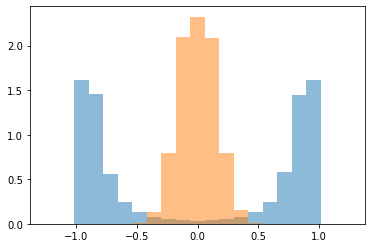

In [121]:
plt.hist(np.mean(x0,axis = 1),bins = 21,range=(-1.25,1.25),alpha = 0.5,density=  True)
plt.hist(np.mean(np.sign(x_recon),axis=1),bins = 21,range=(-1.25,1.25),alpha = 0.5,density=  True)

In [128]:
def Dkl(x0,x_recon):
    eps = 1e-05
    c1,tmp = np.histogram(np.mean(x0,axis = 1),bins = 21,range=(-1.25,1.25),density = True)
    c2,tmp = np.histogram(np.mean(x_recon,axis = 1),bins = 21,range=(-1.25,1.25),density = True)
    return np.sum(c1*np.log((c1+eps)/(c2+eps)))

In [129]:
Dkl(x0,x_recon)

10.025316061826237